# **Assignment #1 Reinforcement Learning**

In [1]:
import sys
sys.path.append("src")
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import random
from gridworld import GridWorld
from value_iteration_agent import Agent


## *Problem 1 -> Pick-and-Place Robot*

Model a simple Pick-and-Place robot as an MDP and build a Gym-style environment. I solve this using a 2D space.


> **States (S):** Each state is defined as (x,y,v_x,v_y,h), where (x,y)is the gripper position, (v_x,v_y)the velocity, and ha binary flag for holding the object.


> **Actions (A):** {move left, move right, move up, move down, open gripper, close gripper}.

> **Transitions (P):** Determined by the environment’s physics — actions update the gripper’s position, velocity, and whether it holds the object.

> **Rewards (R):**
- +100 for successfully placing the object at the goal. _A strong positive reward signals the main goal of the task (placing the object at B). Without this, the agent wouldn’t know what “success” means._
- –1 per timestep. _Encourages the robot to complete the task quickly, instead of wasting time wandering_
- –5 for jerky motion (encourages smoothness). _Penalizes sharp velocity changes to teach the robot to move smoothly, not just fast._
- –10 if the object is dropped. _Prevents careless opening of the gripper before reaching the target._
- +1 for moving closer to the object (if empty) or the goal (if holding). _This helps the agent learn faster by rewarding progress, not just the final goal._

> **Policy (π):** The RL agent learns a mapping s→a, selecting actions that maximize expected return (fast, smooth, successful pick-and-place).


In [2]:
class PickAndPlaceEnv:
    def __init__(self):
        # State = (x, y, vx, vy, h)
        self.state = None
        self.goal = np.array([5, 5])      # target location (B)
        self.object_pos = np.array([2, 2])  # object location (A)
        self.max_steps = 10
        self.steps = 0
        self.action_space = 6  # {left, right, up, down, open, close}

    def reset(self):
        # Reset environment
        self.state = np.array([0, 0, 0, 0, 0])  # (x, y, vx, vy, h=0)
        self.steps = 0
        return self.state

    def step(self, action):
        x, y, vx, vy, h = self.state
        self.steps += 1
        reward = -1  # per timestep penalty

        # --- Actions ---
        if action == 0: x -= 1  # left
        elif action == 1: x += 1  # right
        elif action == 2: y += 1  # up
        elif action == 3: y -= 1  # down
        elif action == 4: h = 0   # open gripper
        elif action == 5: 
            if (x, y) == tuple(self.object_pos):  
                h = 1  # grab object

        # --- Rewards ---
        # 1. Success reward
        if h == 1 and (x, y) == tuple(self.goal):  
            reward += 100
            done = True
        else:
            done = False

        # 2. Jerky movement penalty
        new_vx, new_vy = x - self.state[0], y - self.state[1]
        if abs(new_vx - vx) + abs(new_vy - vy) > 1:
            reward -= 5

        # 3. Drop penalty
        if action == 4 and self.state[4] == 1 and (x, y) != tuple(self.goal):
            reward -= 10

        # 4. Closer shaping reward
        prev_pos = self.state[:2]
        if self.state[4] == 0:  # not holding yet
            prev_dist = np.linalg.norm(self.object_pos - prev_pos)
            new_dist  = np.linalg.norm(self.object_pos - np.array([x,y]))
        else:  # holding object
            prev_dist = np.linalg.norm(self.goal - prev_pos)
            new_dist  = np.linalg.norm(self.goal - np.array([x,y]))
        if new_dist < prev_dist:
            reward += 1

        # Update state
        self.state = np.array([x, y, new_vx, new_vy, h])

        # Episode termination
        if self.steps >= self.max_steps:
            done = True

        return self.state, reward, done, {}

    def render(self):
        print(f"Gripper: ({self.state[0]}, {self.state[1]}) | Holding: {self.state[4]}")


### *Testing the Environment*

In [3]:
env = PickAndPlaceEnv()
state = env.reset()
print("Initial State:", state)

done = False
while not done:
    action = np.random.randint(0, env.action_space)  # random action
    next_state, reward, done, info = env.step(action)
    print(f"Action: {action}, Next State: {next_state}, Reward: {reward}")
    env.render()


Initial State: [0 0 0 0 0]
Action: 5, Next State: [0 0 0 0 0], Reward: -1
Gripper: (0, 0) | Holding: 0
Action: 3, Next State: [ 0 -1  0 -1  0], Reward: -1
Gripper: (0, -1) | Holding: 0
Action: 3, Next State: [ 0 -2  0 -1  0], Reward: -1
Gripper: (0, -2) | Holding: 0
Action: 3, Next State: [ 0 -3  0 -1  0], Reward: -1
Gripper: (0, -3) | Holding: 0
Action: 1, Next State: [ 1 -3  1  0  0], Reward: -5
Gripper: (1, -3) | Holding: 0
Action: 4, Next State: [ 1 -3  0  0  0], Reward: -1
Gripper: (1, -3) | Holding: 0
Action: 0, Next State: [ 0 -3 -1  0  0], Reward: -1
Gripper: (0, -3) | Holding: 0
Action: 1, Next State: [ 1 -3  1  0  0], Reward: -5
Gripper: (1, -3) | Holding: 0
Action: 2, Next State: [ 1 -2  0  1  0], Reward: -5
Gripper: (1, -2) | Holding: 0
Action: 1, Next State: [ 2 -2  1  0  0], Reward: -5
Gripper: (2, -2) | Holding: 0


## *Problem 2 -> 2x2 Gridworld:*

Model a simple Pick-and-Place robot as an MDP and build a Gym-style environment.

**_Based on:_**

- State Space (S): s1, s2, s3, s4.
- Action Space (A): up, down, left, right.
- Initial Policy (π): For all states, π(up|s) = 1.
- Transition Probabilities P(s′|s, a):
    - If the action is valid (does not run into a wall), the transition is deterministic.
    - Otherwise, s′ = s.
- Rewards R(s):
    - R(s1) = 5 for all actions a.
    - R(s2) = 10 for all actions a.
    - R(s3) = 1 for all actions a.
    - R(s4) = 2 for all actions a.

**_Assumptions_**
Using a discount factor γ = 0.9.
Initial values 𝑉0(𝑠)=0 for all 𝑠

**_Transition map (next state for each action):_**
- From s1: up→s1, down→s3, left→s1, right→s2.
- From s2: up→s2, down→s4, left→s1, right→s2.
- From s3: up→s1, down→s3, left→s3, right→s4.
- From s4: up→s2, down→s4, left→s3, right→s4.

**_Value-iteration update:_**

Vk+1​(s) = R(s) + γmaxa​[Vk​(s′)] 


### *Iteration 1*


**1. Show the initial value function (V) for each state.**
V0​(s1)=0, V0​(s2)=0, V0​(s3)=0, V0​(s4)=0.

**2. Perform value function updates (One-step Bellman optimality backup)**
- For each state s and action a:
Since all V₀≡0, the max term is 0.
- V(k+1)(s)=r(s)+0
- V(1)(s1​)=r(s1​), V(1)(s2​)=r(s2​), V(1)(s3​)=r(s3​), V(1)(s4​)=r(s4​)

**3. Show the updated value function.**
>    - V1​(s1)=5, V1​(s2)=10, V1​(s3)=1, V1​(s4)=2

_Policy improvement:_
Greedy policy after Iter. 1, from 𝑉1
Goal: given 𝑉𝜋 improve 𝜋 greedily.
- Q1​(s,a)=R(s)+γV1​(s′)
- due to 𝑉0=0 , Q1​(s,a)=R(s)
    - s1: up/left→ 5+0.9⋅5=9.5; down→5+0.9⋅1=5.9; right→ 5+0.9⋅10=14 ⇒ **pick right**.
	- s2: up/right→ 10+0.9⋅10=19; down→11.8; left→14.5 ⇒ **pick up or right (tie)**.
	- s3: up→ 1+0.9⋅5=5.5; right→ 2.8; down/left→ 1.9 ⇒ **pick up**.
	- s4: up→ 2+0.9⋅10=11; right/down→ 3.8; left→ 2.9 ⇒ **pick up**


### *Iteration 2*
Using V1 to calculate V2

**1. Show the initial value function (V) for each state.**
V1​(s1)=5, V1​(s2)=10, V1​(s3)=1, V1​(s4)=2.

**2. Perform value function updates.**
- V(k+1)(s)=r(s)+ γmaxa​[Vk​(s′)]

- V2(s1)=5 +0.9 * max{V1(s1=5), V1(s3=1), V1(s1=5), V1(s2=10)} =5+0.9⋅10 =14
- V2(s2)=10 +0.9 * max{10,2,5,10} =10+0.9⋅10 =19
- V2(s3)=1 +0.9 * max{5,1,1,2} =1+0.9⋅5 =5.5
- V2(s4)=2 +0.9 * max{10,2,1,2} =2+0.9⋅10 =11


**3. Show the updated value function.**
>  V2​(s1)=14, V2​(s2)=19, V2​(s3)=5.5, V2​(s4)=11

_Policy improvement:_
Greedy policy after Iter. 1, from 𝑉2
Goal: given 𝑉𝜋 improve 𝜋 greedily.
- Q1​(s,a)=R(s)+γV1​(s′)
    - s1 (R=5)
    up: 17.6 (→ s1) · down: 9.95 (→ s3) · left: 17.6 (→ s1) · right: 22.1 (→ s2)
    - s2 (R=10)
    up: 27.1 (→ s2) · down: 19.9 (→ s4) · left: 22.6 (→ s1) · right: 27.1 (→ s2)
    - s3 (R=1)
    up: 13.6 (→ s1) · down: 5.95 (→ s3) · left: 5.95 (→ s3) · right: 10.9 (→ s4)
    - s4 (R=2)
    up: 19.1 (→ s2) · down: 11.9 (→ s4) · left: 6.95 (→ s3) · right: 11.9 (→ s4)


## *Problem 3 -> 5x5 Gridworld*

Model a simple Pick-and-Place robot as an MDP and build a Gym-style environment. I solve this using a 2D space.


### Task1: Update MDP Code
Rebuild the reward structure based on the matrix given in the assignment.

**Build environment and update reward by state type**
1. Update the reward function to be a list of reward based on whether the state is terminal, grey,
or a regular state.

In [4]:
# create the environment (5x5 for example)
env = GridWorld(env_size=5)

# Define the grey states 
grey_states = {(1,2), (3,0), (0,4)}

# Define reward values for each type
rewards_map = {
    "regular": -1.0,
    "grey": -5.0,
    "terminal": 10
}

# Function to build the reward matrix based on state types
def build_rewards_by_type(env, grey_states, rewards_map):
    # start with all regular rewards
    R = np.full((env.env_size, env.env_size), rewards_map["regular"], dtype=float)    
    # assign grey rewards
    for (i,j) in grey_states:
        R[i,j] = rewards_map["grey"]    
    # assign terminal reward
    R[env.terminal_state] = rewards_map["terminal"]    
    return R

# Replace the environment's reward matrix
env.reward = build_rewards_by_type(env, grey_states, rewards_map)

# Function to print the reward matrix 
def print_value_table(V):
    for i in range(V.shape[0]):
        print(" ".join(f"{V[i, j]:6.1f}" for j in range(V.shape[1])))


**Print the updated reward matrix.**


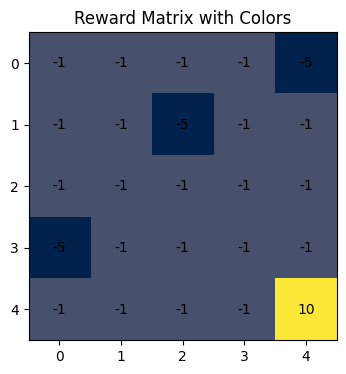

In [5]:
plt.figure(figsize=(4,4))
plt.imshow(env.reward, cmap="cividis", origin="upper")

# Annotate each cell with its reward value
for i in range(env.reward.shape[0]):
    for j in range(env.reward.shape[1]):
        plt.text(j, i, int(env.reward[i, j]), ha="center", va="center", color="black")

plt.title("Reward Matrix with Colors")
plt.show()


**Run existing Value Iteration and display V*** **and greedy policy π**

2. Run the existing code developed in class and obtain the optimal state-values and optimal policy.
Provide a figures of the gridworld with the obtained V∗ and π∗ (You can manually create a table).

In [6]:
# Create environment
agent = Agent(env)

start_time = time.time()
max_iterations = 1000
theta = 0.01
agent.gamma = 0.9

# run value iteration normally
for it in range(max_iterations):
    delta = 0
    new_V = np.copy(agent.get_value_function())
    for i in range(env.env_size):
        for j in range(env.env_size):
            if not env.is_terminal_state(i, j):
                new_V[i, j], _, _ = agent.calculate_max_value(i,j)
                delta = max(delta, abs(agent.V[i,j] - new_V[i,j]))
    agent.update_value_function(new_V)
        # stopping criteria
    if delta < theta:
        print(f"Converged in {it+1} iterations")
        break

end_time = time.time()


Converged in 9 iterations


In [7]:
print("Execution time", end_time - start_time, "seconds")

Execution time 0.0031881332397460938 seconds


In [8]:
# Compute policy improvement 
agent.update_greedy_policy()
ARROWS = {
    0: "→",   # Right
    1: "←",   # Left
    2: "↓",   # Down
    3: "↑",   # Up
}
V_star = agent.get_value_function()
pi_star = agent.get_policy()   


**Heatmap for V*** **with arrows for π**

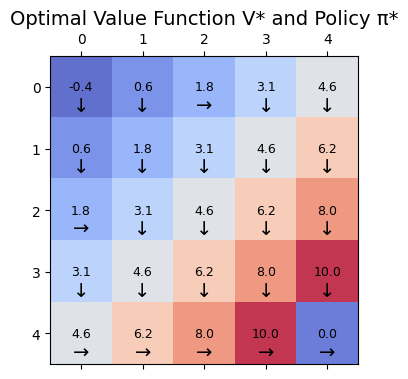

In [9]:
def plot_heatmap_with_policy(V, pi, title="V* with π*"):
    n = V.shape[0]
    fig, ax = plt.subplots(figsize=(4,4))
    cax = ax.matshow(V, cmap="coolwarm", alpha=0.8)


    # Add values and arrows on each cell
    for i in range(n):
        for j in range(n):
            ax.text(j, i, f"{V[i,j]:.1f}", va="center", ha="center", color="black", fontsize=9)
            if pi is not None and pi[i,j] in ARROWS:
                ax.text(j, i+0.3, ARROWS[pi[i,j]], va="center", ha="center", color="black", fontsize=14)
    
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(range(n))
    ax.set_yticklabels(range(n))
    ax.set_title(title, fontsize=14)
    plt.show()

# Run it with your Value Iteration results
plot_heatmap_with_policy(V_star, pi_star, "Optimal Value Function V* and Policy π*")


### Task 2: Value Iteration Variations

1. In-Place Value Iteration: Use a single array to store the state values. This means that you
update the value of a state and immediately use that updated value in the subsequent updates.

In [10]:
# Same setup as in Task 1
env_inplace = GridWorld(env_size=5)
# Replacing the custom reward matrix and assigns it to the environment
env_inplace.reward = build_rewards_by_type(env_inplace, grey_states, rewards_map)
# Create the agent
agent = Agent(env_inplace)
agent.gamma = 0.9

# In-place Value Iteration
start_time = time.time()
max_iterations = 1000
theta = 0.01

for it in range(max_iterations):
    delta = 0
    for i in range(env.env_size):
        for j in range(env.env_size):
            if not env.is_terminal_state(i, j):
                # In-place update: directly overwrite V[i,j]
                new_value, _, _ = agent.calculate_max_value(i, j)
                delta = max(delta, abs(agent.V[i,j] - new_value))
                # Each state's value is updated directly in agent.V.
                agent.V[i,j] = new_value
    if delta < theta:
        print(f"Converged in {it+1} iterations")
        break

end_time = time.time()


Converged in 9 iterations


In [11]:
print("Execution time (in-place):", end_time - start_time, "seconds")

Execution time (in-place): 0.0029916763305664062 seconds


In [12]:
#Compute and display optimal policy
agent.update_greedy_policy()
V_star_inplace = agent.get_value_function()
pi_star_inplace = agent.get_policy()

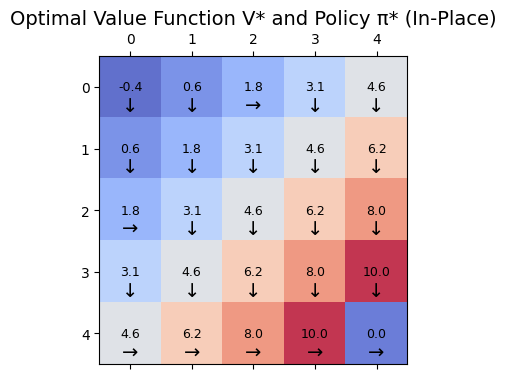

In [13]:
# Run it with your Value Iteration results
plot_heatmap_with_policy(V_star_inplace, pi_star_inplace, "Optimal Value Function V* and Policy π* (In-Place)")


### **Notes on Computational Complexity**

- Both variations (normal and in-place) converge to the same optimal value function V^*and optimal policy π^*.
- In our 5x5 GridWorld, both required 9 iterations to converge with θ = 0.01.
- The execution time was 0.0031 seg (normal) vs 0.0029 seg (in-place).
- The theoretical computational complexity is the same, O(∣S∣⋅∣A∣)per iteration. However, in-place updates can reduce the total number of iterations in larger environments, since each state update immediately benefits from previously updated neighbor values.



## *Problem 4 ->Off-policy Monte Carlo with Importance Sampling*

estimate the value function for the given gridworld. Use a fixed behavior policy b(a|s) (e.g., a random policy) to generate episodes and a greedy target policy.


**Helpers functions:**

These helper functions are used to manage actions and policies in the gridworld: 
- **valid_actions** checks which moves are possible from a state, **behavior_policy_sample** generates a random valid action under the behavior policy with its probability, and **greedy_action** selects the best action according to the current Q-values for the target policy.

Together they allow us to generate episodes and update the greedy policy during the Monte Carlo algorithm.

In [14]:
env = GridWorld(env_size=5)
env.reward = build_rewards_by_type(env, grey_states, rewards_map)

ACTIONS = list(range(len(env.get_actions())))   # [0:→, 1:←, 2:↓, 3:↑]

# Helpers: valid actions, behavior policy b, greedy target π
#Chechk which actions are valid from the gridworld environment
def valid_actions(env, i, j):
    """
    Returns a list of action indices that lead to a different valid state.
    This avoids 'bouncing' in place due to invalid moves.
    """
    valid = []
    for a in ACTIONS:
        di, dj = env.get_actions()[a]
        ni, nj = i + di, j + dj
        if env.is_valid_state(ni, nj):
            valid.append(a)
    return valid

# Choose an action uniformly at random from valid actions and return its probability 
# E.g., (0,0) valid actions (0, 0.5) o (2, 0.5) --> 1/2
def behavior_policy_sample(env, i, j):
    """
    Uniform random over valid actions.
    Returns (action_index, b_prob).
    """
    va = valid_actions(env, i, j)
    # Fallback (shouldn't happen): if no valid actions, pick any
    if len(va) == 0:
        return random.choice(ACTIONS), 1.0/len(ACTIONS)
    a = random.choice(va)
    b_prob = 1.0 / len(va)
    return a, b_prob

# Choose the greedy action wrt Q(s,a)
# E.g., (2,3) Q(2,3,→)=5, Q(2,3,↓)=7 --> action 2 (Down)
def greedy_action(Q, i, j):
    """
    Deterministic greedy wrt Q(s,a). Ties broken by lowest action index.
    Only considers valid actions for the target policy.
    """
    va = valid_actions(env, i, j)
    best_a = va[0]
    best_q = Q[i, j, best_a]
    for a in va[1:]:
        if Q[i, j, a] > best_q:
            best_q, best_a = Q[i, j, a], a
    return best_a

**Episode Generation:**

The next two functions are used to create episodes for Monte Carlo learning: 
- **random_non_terminal_stat**e selects a random starting point in the grid that is not terminal, and **generate_episode** simulates a full trajectory from that start by following the behavior policy until reaching a terminal state or the step limit, recording states, actions, rewards, and probabilities for later updates.

In [15]:
# Generate an episode using behavior policy b
def random_non_terminal_state(env):
    """
    Sample a random start state that is not terminal.
    """
    while True:
        i = random.randrange(env.env_size)
        j = random.randrange(env.env_size)
        if not env.is_terminal_state(i, j):
            return (i, j)

def generate_episode(env, gamma=0.9, max_steps=200):
    """
    Returns a list of transitions: [(i,j,a,r,b_prob), ...] until terminal or max_steps.
    We store b_prob for importance sampling weights later.
    """
    episode = []
    i, j = random_non_terminal_state(env)
    for _ in range(max_steps):
        a, b_prob = behavior_policy_sample(env, i, j)
        ni, nj, r, done = env.step(a, i, j)
        episode.append((i, j, a, r, b_prob))
        i, j = ni, nj
        if done:
            break
    return episode

**Function off-policy Monte Carlo with IS**

It generates many episodes using the behavior policy, then goes backwards through each episode to compute returns, applies importance sampling weights to correct for the difference between the behavior and greedy target policy, and updates the Q-values; in the end, it estimates the **value function 𝑉(𝑠)** and the **greedy policy 𝜋(𝑠).**

In [ ]:
# Off-policy MC control with Weighted IS (Sutton & Barto)

def offpolicy_mc_control(env, num_episodes=5000, gamma=0.9):
    """
    Estimates Q(s,a) off-policy using a fixed behavior b and a greedy target π.
    Uses weighted importance sampling with backward updates and cumulative weights C(s,a).
    """
    n = env.env_size
    nA = len(ACTIONS)
    Q = np.zeros((n, n, nA), dtype=float)
    C = np.zeros_like(Q)  # cumulative weights for each (s,a)

    start = time.time()
    for ep in range(1, num_episodes + 1):
        episode = generate_episode(env, gamma=gamma, max_steps=200)

        G = 0.0
        W = 1.0
        # Backward pass through the episode
        for t in reversed(range(len(episode))):
            i, j, a, r, b_prob = episode[t]
            G = gamma * G + r

            # Update cumulative weight and Q via weighted IS
            C[i, j, a] += W
            # Incremental mean: Q <- Q + (W/C) * (G - Q)
            Q[i, j, a] += (W / C[i, j, a]) * (G - Q[i, j, a])

            # If the action taken is NOT greedy under current Q, stop (π(a|s)=0 beyond this point)
            greedy_a = greedy_action(Q, i, j)
            if a != greedy_a:
                break

            # Otherwise, continue weighting: multiply by 1 / b(a|s)
            # (since π(a|s)=1 for the greedy action)
            W *= 1.0 / b_prob

    elapsed = time.time() - start
    return Q, elapsed


**Run the off-policy MC control algorithm**


[MC Off-Policy with IS] Episodes: 5000, Time: 1.1185s


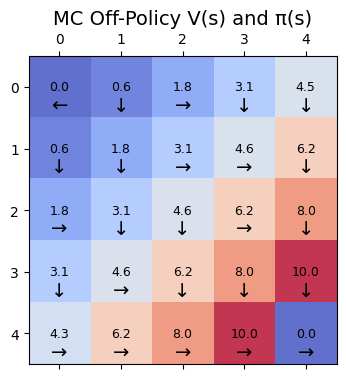

In [ ]:
# Compile  MC, derive V and π, and print tables

gamma = 0.9
episodes = 5000  # you can increase to reduce variance

Q_mc, mc_time = offpolicy_mc_control(env, num_episodes=episodes, gamma=gamma)

V_mc = Q_mc.max(axis=2)
PI_mc = np.argmax(Q_mc, axis=2)  # greedy policy from Q_mc


print(f"\n[MC Off-Policy with IS] Episodes: {episodes}, Time: {mc_time:.4f}s")


# Optional: arrows for visualization
plot_heatmap_with_policy(V_mc, PI_mc, "MC Off-Policy V(s) and π(s)")

### **Comparison: Value Iteration vs Monte Carlo Off-policy (IS)**

| Method                  | Time (s)   | Iterations/Episodes | Complexity                       | Notes                                                   |
|--------------------------|-----------:|---------------------|----------------------------------|---------------------------------------------------------|
| Value Iteration (normal) | 0.00319    | 9 iterations        | O(S*A) per iteration         | Exact given the model; very fast and stable             |
| Value Iteration (in-place) | 0.00299 | 9 iterations        | O(S*A) per iteration           | Same V* and π*; slightly faster; advantage in larger grids |
| Monte Carlo (Off-policy IS) | 1.1062 | 5000 episodes       | O(episodes × avg. episode length) | Approximates V(s); higher variance; same policy trend but noisier |

**Summary:** 

> In this 5×5 gridworld, both versions of Value Iteration (VI) converged in 9 iterations and under 0.004 seconds, **producing exact and stable results**. 

The difference comes from the fact that VI performs deterministic sweeps over all states, while **Monte Carlo requires thousands of episodes to reduce variance**. 

> Monte Carlo Off-policy with Importance Sampling required 5000 episodes and about 1.1 seconds to approximate the value function.

Iterations and episodes are not the same: one iteration updates all states, while one episode only visits some states and actions. 

> VI (normal and in-place) produced the same tables with consistent values (for example: (4,3)=10, (0,0)≈−0.4 with γ=0.9). MC Off-policy showed the same gradient trend toward the goal but with less precision in distant states (for example: (0,0)=0 in MC vs −0.4 in VI).

> In all three cases, the greedy policy π(s) was the same, pointing to the goal (down/right). *Monte Carlo can show small fluctuations in far states when Q-values have high variance*.

